In [1]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
torch.manual_seed(0)

In [2]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt

from PIL import Image

In [14]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap = 'gray')    
    plt.title('y = ' + str(data_sample[1]))

In [5]:
IMAGE_SIZE = 16

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [6]:
dataset_train = dsets.FashionMNIST(root = '.fashion/data', train = True, transform = composed, download = True)
dataset_val = dsets.FashionMNIST(root = '.fashion/data', train = False, transform = composed, download = True)

0it [00:00, ?it/s]

26427392it [00:05, 4708041.17it/s]                              


Extracting .fashion/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to .fashion/data/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 33949.30it/s]                           
0it [00:00, ?it/s]

Extracting .fashion/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to .fashion/data/FashionMNIST/raw


4423680it [00:17, 460320.74it/s]                             
0it [00:00, ?it/s]

Extracting .fashion/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to .fashion/data/FashionMNIST/raw



8192it [00:00, 12353.97it/s]            

Extracting .fashion/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to .fashion/data/FashionMNIST/raw
Processing...
Done!



4423680it [00:29, 460320.74it/s]

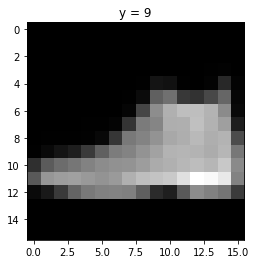

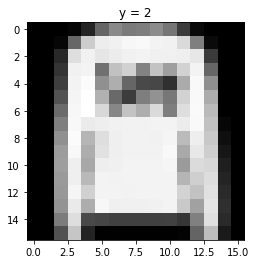

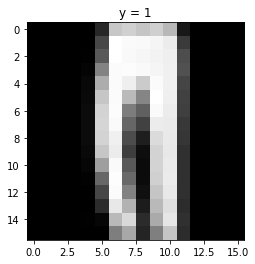

In [15]:
for n, data_sample in enumerate(dataset_val):
    show_data(data_sample)
    plt.show()
    if n == 2:
        break

In [34]:
def get_conv_result_size(width, kernel_size, padding, stride):
    rst = (width - kernel_size + 2*padding)/stride + 1
    return int(rst)

In [35]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(x.size(0), -1)

In [50]:
class CNN_batch(nn.Module):
    def __init__(self, out_1 = 16, out_2 = 32, number_of_classes = 10):
        super(CNN_batch, self).__init__()
        self.network = nn.Sequential()
        
        # Default stride = 1
        self.network.add_module('conv1', nn.Conv2d(1, out_1, kernel_size = 5, padding = 2))        
        img_size = get_conv_result_size(IMAGE_SIZE, 5, 2, 1)
        self.network.add_module('batch_norm1', nn.BatchNorm2d(out_1))
        self.network.add_module('ReLU1', nn.ReLU())
        # Default stride = kernel_size
        self.network.add_module('max_pooling1', nn.MaxPool2d(kernel_size = 2))        
        img_size = get_conv_result_size(img_size, 2, 0, 2)
        
        self.network.add_module('conv2', nn.Conv2d(out_1, out_2, kernel_size = 5, stride = 1, padding = 2 ))
        img_size = get_conv_result_size(img_size, 5, 2, 1)
        self.network.add_module('batch_norm2', nn.BatchNorm2d(out_2))
        self.network.add_module('ReLU2', nn.ReLU())
        self.network.add_module('max_pooling2', nn.MaxPool2d(kernel_size = 2))
        img_size = get_conv_result_size(img_size, 2, 0, 2)
        
        self.network.add_module('Flatten', nn.Flatten())
        self.network.add_module('FC', nn.Linear(out_2 * img_size * img_size, number_of_classes))        
        self.network.add_module('batch_norm3', nn.BatchNorm1d(number_of_classes))
        
        self.cuda()
        
    def forward(self, x):
        out = self.network(x.to(device))
        return out
        

In [62]:
class CNN(nn.Module):
    def __init__(self, out_1 = 16, out_2 = 32, number_of_classes = 10):
        super(CNN, self).__init__()
        self.network = nn.Sequential()
        
        # Default stride = 1
        self.network.add_module('conv1', nn.Conv2d(in_channels = 1, out_channels = out_1, kernel_size = 5, padding = 2))        
        img_size = get_conv_result_size(IMAGE_SIZE, 5, 2, 1)        
        self.network.add_module('ReLU1', nn.ReLU())
        # Default stride = kernel_size
        self.network.add_module('max_pooling1', nn.MaxPool2d(kernel_size = 2))        
        img_size = get_conv_result_size(img_size, 2, 0, 2)
        
        self.network.add_module('conv2', nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, stride = 1, padding = 2 ))
        img_size = get_conv_result_size(img_size, 5, 2, 1)        
        self.network.add_module('ReLU2', nn.ReLU())
        self.network.add_module('max_pooling2', nn.MaxPool2d(kernel_size = 2))
        img_size = get_conv_result_size(img_size, 2, 0, 2)
        
        self.network.add_module('Flatten', nn.Flatten())
        self.network.add_module('FC', nn.Linear(out_2 * img_size * img_size, number_of_classes))        
        self.cuda()
        
    def forward(self, x):
        out = self.network(x.to(device))
        return out
        

In [63]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=100 )
test_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=100 )

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

True
cuda


In [65]:
model = CNN(out_1 = 16, out_2 = 32, number_of_classes = 10).to(device)
model_bn = CNN_batch(out_1 = 16, out_2 = 32, number_of_classes = 10).to(device)

In [73]:
import time
start_time = time.time()

cost_list = []
accuracy_list = []
N_test = len(dataset_val)
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()
n_epochs = 5

for epoch in range(n_epochs):
    cost = 0
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z.to('cpu'), y)
        loss.backward()
        optimizer.step()
        cost += loss.item()
    correct = 0
    
    model.eval()
    for x_test, y_test in test_loader:
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat.to('cpu') == y_test).sum().item()
    accuracy = correct / N_test
    accuracy_list.append(accuracy)
    cost_list.append(cost)

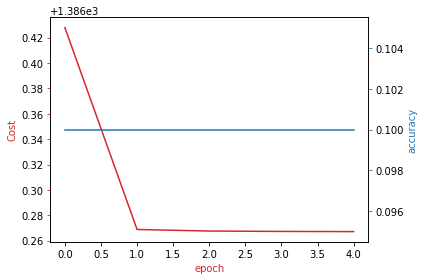

In [74]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()